In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, IterableDataset, Subset, SubsetRandomSampler

from torchvision.datasets import MNIST,CIFAR10
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

## Data

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'
device

'mps'

In [3]:
dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_dataset, valid_dataset = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

## Network

In [5]:
def toy_net():
    return nn.Sequential(
        nn.Conv2d(1, 20, 7),
        nn.ReLU(),
        nn.Conv2d(20, 40, 7),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(2560, 10)
    )
toy_net()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(7, 7), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2560, out_features=10, bias=True)
)

## Server-Clients configuration

In [6]:
# underlying module must be of the same class in server & clients
server = Server(toy_net().to(device))
N = 8 # number of clients
partition = partition_by_class(train_dataset)

# for even (iid) split -> set alpha to very big value like 10e8 or very small like 10e-8
# here alpha=0.1 creates very uneven (non-iid) splits
clients = [Client(i,d,toy_net().to(device)) for i,d in enumerate(split(partition,N,alpha=0.1),start=1)]

In [7]:
def run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []
    for i in range(rounds):
        print(f'Start Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
                    #train(device, state_dict, epochs, batch_size, opt, lr, **kwargs)
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''After round {i+1} :
        - training loss = {train_loss:.4f}
        - training accuracy = {train_acc:.4f}
        - validation loss = {valid_loss:.4f}
        - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append((train_loss, valid_loss, train_acc, valid_acc))
    return history

## SGD

In [28]:
rounds = 10
batch_size = 128
epochs = 3
lr = 1e-3

Start Round 1 ...
1: Loss = 0.1182, Accuracy = 0.9707
2: Loss = 0.4809, Accuracy = 0.8515
3: Loss = 0.3633, Accuracy = 0.8987
4: Loss = 0.3003, Accuracy = 0.9171
5: Loss = 0.7175, Accuracy = 0.8248
6: Loss = 0.4119, Accuracy = 0.8835
7: Loss = 0.3776, Accuracy = 0.9204
8: Loss = 0.2646, Accuracy = 0.9453
After round 1 :
        - training loss = 1.5032
        - training accuracy = 0.6051
        - validation loss = 1.5037
        - validation accuracy = 0.6083
        
Start Round 2 ...
1: Loss = 0.0823, Accuracy = 0.9819
2: Loss = 0.4294, Accuracy = 0.8648
3: Loss = 0.2752, Accuracy = 0.9359
4: Loss = 0.2632, Accuracy = 0.9197
5: Loss = 0.5499, Accuracy = 0.8626
6: Loss = 0.3348, Accuracy = 0.9067
7: Loss = 0.2593, Accuracy = 0.9256
8: Loss = 0.2047, Accuracy = 0.9557
After round 2 :
        - training loss = 1.3203
        - training accuracy = 0.6614
        - validation loss = 1.3177
        - validation accuracy = 0.6638
        
Start Round 3 ...
1: Loss = 0.0643, Accuracy = 0.9

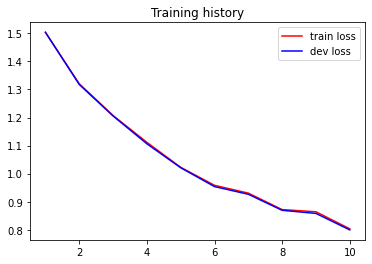

In [29]:
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.SGD,lr)
plot_loss_epoch(history)

## Adam

Start Round 1 ...
1: Loss = 0.0187, Accuracy = 0.9931
2: Loss = 0.0588, Accuracy = 0.9835
3: Loss = 0.0631, Accuracy = 0.9807
4: Loss = 0.0274, Accuracy = 0.9918
5: Loss = 0.2848, Accuracy = 0.9061
6: Loss = 0.0488, Accuracy = 0.9841
7: Loss = 0.0903, Accuracy = 0.9782
8: Loss = 0.0552, Accuracy = 0.9858
After round 1 :
        - training loss = 0.8994
        - training accuracy = 0.7849
        - validation loss = 0.8998
        - validation accuracy = 0.7848
        
Start Round 2 ...
1: Loss = 0.0057, Accuracy = 0.9970
2: Loss = 0.0304, Accuracy = 0.9898
3: Loss = 0.0113, Accuracy = 0.9975
4: Loss = 0.0152, Accuracy = 0.9950
5: Loss = 0.0765, Accuracy = 0.9766
6: Loss = 0.0242, Accuracy = 0.9923
7: Loss = 0.0071, Accuracy = 0.9987
8: Loss = 0.0265, Accuracy = 0.9943
After round 2 :
        - training loss = 1.0114
        - training accuracy = 0.8269
        - validation loss = 1.0136
        - validation accuracy = 0.8273
        
Start Round 3 ...
1: Loss = 0.0032, Accuracy = 0.9

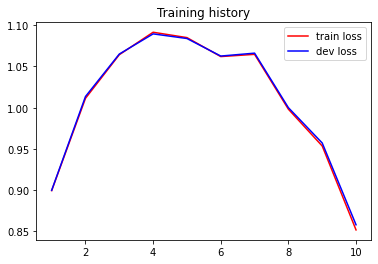

In [30]:
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.Adam,lr)
plot_loss_epoch(history)

## LR selection

In [19]:
rounds = 10
batch_size = 128
epochs = 3

In [23]:
lrs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

best_result = 0
best_lr = lrs[0]

for lr in lrs:

    cv_train_acc = []
    cv_valid_acc = []

    # assign folds
    folds=KFold(n_splits=5,shuffle=True,random_state=42)

    # split training dataset in folds
    folded_train = folds.split(np.arange(len(dataset)))

    for fold, (train_idx,val_idx) in enumerate(folded_train):

        print("Current fold: {}".format(fold))

        # create train and validation subsets
        train_subset = Subset(dataset, train_idx)
        valid_subset = Subset(dataset, val_idx)

        # split data between users
        partition = partition_by_class(train_subset)

        # for even (iid) split -> set alpha to very big value like 10e8 or very small like 10e-8
        # here alpha=0.1 creates very uneven (non-iid) splits
        clients = [Client(i,d,toy_net().to(device)) for i,d in enumerate(split(partition,N,alpha=0.1),start=1)]

        # get current fold history
        fold_history = run(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optim.Adam,lr)

        # save data for full round of cross validation metrics
        cv_train_acc.append(fold_history[-1][2])
        cv_valid_acc.append(fold_history[-1][3])

        # reset server parameters before next fold
        server.reset_weights()

    print(f'''performance of lr: {lr} :
            - training accuracy = {np.mean(cv_train_acc)}
            - validation accuracy = {np.mean(cv_valid_acc)}
            ''')

    current_perf = np.mean(cv_train_acc) + np.mean(cv_valid_acc)

    if  current_perf > best_result:
        best_result = current_perf
        best_lr = lr

print(f"Best learning rate is: {best_lr}")
#Best rate - 0.005
    

Current fold: 0
Start Round 1 ...
1: Loss = 0.2768, Accuracy = 0.9185
2: Loss = 0.3180, Accuracy = 0.9244
3: Loss = 0.3644, Accuracy = 0.8453
4: Loss = 0.4526, Accuracy = 0.8517
5: Loss = 0.4909, Accuracy = 0.8405
6: Loss = 0.5108, Accuracy = 0.8643
7: Loss = 0.2816, Accuracy = 0.9158
8: Loss = 0.5401, Accuracy = 0.9097
After round 1 :
        - training loss = 2.1986
        - training accuracy = 0.2364
        - validation loss = 2.1762
        - validation accuracy = 0.2413
        
Start Round 2 ...
1: Loss = 0.2080, Accuracy = 0.9414
2: Loss = 0.2272, Accuracy = 0.9328
3: Loss = 0.1393, Accuracy = 0.9559
4: Loss = 0.1453, Accuracy = 0.9547
5: Loss = 0.2221, Accuracy = 0.9359
6: Loss = 0.1995, Accuracy = 0.9485
7: Loss = 0.2554, Accuracy = 0.9236
8: Loss = 0.2612, Accuracy = 0.9432
After round 2 :
        - training loss = 1.7730
        - training accuracy = 0.4871
        - validation loss = 1.7410
        - validation accuracy = 0.4910
        
Start Round 3 ...
1: Loss = 0.1648